# Trait correlations study 4 analysis

Import packages:

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from scipy.stats import rankdata, pearsonr
import statsmodels.api as sm
from statsmodels.stats.mediation import Mediation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, spearmanr, ttest_ind

def vec_rescale(vec, new_min, new_max):
    '''
    Rescale vector to new min and max value
    '''
    return (new_max - new_min) / ( max(vec) - min(vec) ) * (vec - max(vec)) + new_max

## Data prep

Load in raw data and transform into similarity vectors:

In [15]:
# load raw data
ratings_a = pd.read_csv('ratings4a_raw.csv')
demos_a = pd.read_csv('demo4a_raw.csv')
ratings_b = pd.read_csv('ratings4b_raw.csv')
demos_b = pd.read_csv('demo4b_raw.csv')

# merge ratings and demographics
data_a = ratings_a.merge(demos_a, on='SubjID', how='left')
data_b = ratings_b.merge(demos_b, on='SubjID', how='left')
# peak at ds
display(data_a[:4])
display(data_b[:4])

,SubjID,Study_x,Name,Trial,Picture,Rating,RT,Study_y,IP,age,gender,english,hispanic,race
0,3925473,ratings/TLr4a,assertive,1,CFD-WM-016-001-N.jpg,7,3025,ratings/TLr4a,179.52.238.79,30,female,yes,not,White
1,3925473,ratings/TLr4a,assertive,2,CFD-WM-254-152-N.jpg,4,1605,ratings/TLr4a,179.52.238.79,30,female,yes,not,White
2,3925473,ratings/TLr4a,assertive,3,CFD-WM-036-031-N.jpg,3,2269,ratings/TLr4a,179.52.238.79,30,female,yes,not,White
3,3925473,ratings/TLr4a,assertive,4,CFD-WM-210-057-N.jpg,5,1038,ratings/TLr4a,179.52.238.79,30,female,yes,not,White


,SubjID,Study_x,Name,Trial,Picture,Rating,RT,Study_y,IP,age,gender,english,hispanic,race
0,1159773,ratings/TLr4b,competent,1,CFD-WM-237-052-N.jpg,5,4577,ratings/TLr4b,157.50.13.42,47,male,yes,not,Asian
1,1159773,ratings/TLr4b,competent,2,CFD-WM-039-018-N.jpg,3,1441,ratings/TLr4b,157.50.13.42,47,male,yes,not,Asian
2,1159773,ratings/TLr4b,competent,3,CFD-WM-242-011-N.jpg,5,2435,ratings/TLr4b,157.50.13.42,47,male,yes,not,Asian
3,1159773,ratings/TLr4b,competent,4,CFD-WM-029-023-N.jpg,3,2241,ratings/TLr4b,157.50.13.42,47,male,yes,not,Asian


## Do individuals' beliefs predict their perceptions?

Here we test if specific individual's conceptual associations between traits relate to how correlated their face judgments of those traits are.

In [26]:
# prep a data

data_corr_a = pd.DataFrame(columns=['SubjID','concept_sim','face_corr','l2h_pICC'])

for i,s in enumerate(np.unique(data_a['SubjID'])):
    t_ = pd.pivot_table( data_a[data_a['SubjID'] == s], 
                       index = 'Picture', 
                       columns = 'Name', 
                       values = 'Rating', 
                       aggfunc = np.mean)
    t_ = [s, np.mean(t_['simVote']),
         np.arctanh(pearsonr(t_[:-2]['assertive'],t_[:-2]['caring'])[0]),
         -.5]
    data_corr_a.loc[i] = t_

data_corr_b = pd.DataFrame(columns=['SubjID','concept_sim','face_corr','l2h_pICC'])

for i,s in enumerate(np.unique(data_b['SubjID'])):
    t_ = pd.pivot_table( data_b[data_b['SubjID'] == s], 
                       index = 'Picture', 
                       columns = 'Name', 
                       values = 'Rating', 
                       aggfunc = np.mean)
    t_ = [s, np.mean(t_['simVote']),
         np.arctanh(pearsonr(t_[:-2]['competent'],t_[:-2]['creative'])[0]),
         .5]
    data_corr_b.loc[i] = t_

data_corr_ab = pd.concat([data_corr_a[:4],data_corr_b[:4]])

# normalize concept similarities
data_corr_a['concept_sim'] = zscore(data_corr_a['concept_sim'])
data_corr_b['concept_sim'] = zscore(data_corr_b['concept_sim'])
data_corr_ab['concept_sim'] = zscore(data_corr_ab['concept_sim'])

# check data
display(data_corr_a[:4])
display(data_corr_b[:4])

,SubjID,concept_sim,face_corr,l2h_pICC
0,3925473.0,0.685994,-0.042174,-0.5
1,4085660.0,0.685994,0.052986,-0.5
2,5249144.0,-0.171499,0.034411,-0.5
3,6269782.0,-1.886484,0.124910,-0.5


,SubjID,concept_sim,face_corr,l2h_pICC
0,1159773.0,-0.369274,0.086427,0.5
1,3014192.0,0.861640,0.032881,0.5
2,4888840.0,-0.984732,0.342585,0.5
3,6184504.0,-0.984732,-0.324284,0.5


First plot - all data; second plot - remove outliers informally, concept < z-3


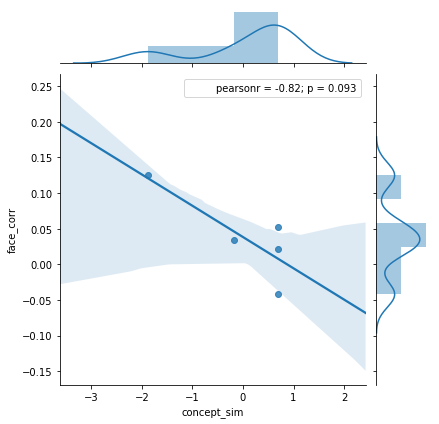

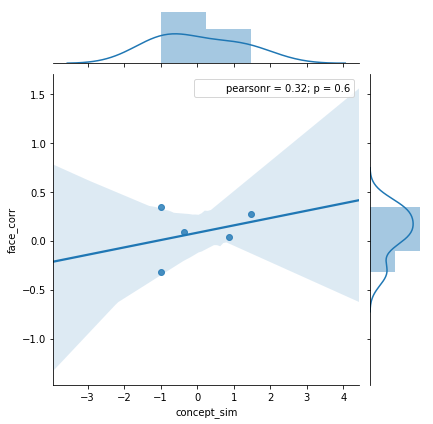

In [28]:
# analyze
print('First plot - all data; second plot - remove outliers informally, concept < z-3')

# all data
sns.jointplot('concept_sim','face_corr', data=data_corr_a, kind="reg")
sns.jointplot('concept_sim','face_corr', data=data_corr_b, kind="reg")

# cut few folks sticking out for all the haters
# data_corr_cutzsub3 = data_corr[data_corr['concept_sim'] > -3]
# sns.jointplot('concept_sim','face_corr', data=data_corr_cutzsub3, kind="reg")

Lastly, test interaction - do high perceiver ICC traits have a different relation than low perceiver ICC traits?

Also, Ryan, can we look at whether certain specific traits stay stable, while others change based on concept_sim? (eg, core traits, eg trust, never change, its the others that change and correlate more or less....

# Summary

?
